## Imports

In [184]:
import os

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
#from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

## Constants

In [186]:
EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 10

root = os.getcwd()


## Load and Process Data

In [187]:
def aggregate_data(df):
    df['hourly_timestamp'] = df['date_forecast'].dt.floor('H')

    df.set_index('hourly_timestamp', inplace=True)

    aggregations = {col: 'median' for col in df.columns if col != 'date_forecast'}
    aggregations['date_forecast'] = 'first'

    df = df.groupby('hourly_timestamp').agg(aggregations).reset_index()

    df.drop(columns=['hourly_timestamp'], inplace=True)
    df['date_forecast'] = df['date_forecast'].dt.floor('H')
    
    return df

In [188]:
def clean_aggregated_data(df):
    df = add_date_features(df.copy())
    df.drop(columns=['snow_density:kgm3'], inplace=True)
    
    if "date_calc" in df.columns:
        df.drop(columns=['date_calc'], inplace=True)
    return df

In [189]:
 # Function to add date features
def add_date_features(X):
    X['hour_sin'] = np.sin(2 * np.pi * X['date_forecast'].dt.hour / 24)
    X['hour_cos'] = np.cos(2 * np.pi * X['date_forecast'].dt.hour / 24)
    X['month_sin'] = np.sin(2 * np.pi * X['date_forecast'].dt.month / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['date_forecast'].dt.month / 12)
    
    return X

In [190]:
def visualize_pv_measurement(merged_data):
    plt.figure(figsize=(10, 5))
    plt.plot(merged_data['date_forecast'], merged_data['pv_measurement'])
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.grid(True)
    plt.show()

### Removal of noise fucntions

In [191]:
def mark_consecutive_identical(series, threshold=23):
    """Mark sequences of threshold or more identical consecutive values with NaN"""
    # Start by finding all the points where the series changes
    diff = series.diff().ne(0)
    # Count consecutive occurrences
    count = (~diff).groupby(diff.cumsum()).cumsum()
    # Mark sequences with threshold or more occurrences with NaN
    series[count >= threshold] = np.nan
    return series


# Remove the bad observations (noise) in pv_measurement
def drop_noise_in_pv_measurement(merged_data):

    # Mark the appropriate rows in 'pv_measurement' with NaN
    merged_data['pv_measurement'] = mark_consecutive_identical(merged_data['pv_measurement'])

    # Drop rows where 'pv_measurement' is NaN
    merged_data.dropna(subset=['pv_measurement'], inplace=True)

    return merged_data

### Removal of correlated features functions

In [192]:
# Drop highly correlated columns

columns_to_drop = [ #need to change and add back some of these columns
            'elevation:m',
            'is_day:idx',
            'snow_density:kgm3',
            'snow_drift:idx',
            'dew_point_2m:K',
            't_1000hPa:K',
            'clear_sky_rad:W',
            'diffuse_rad_1h:J',
            'direct_rad_1h:J',
            'total_cloud_cover:p',
            'pressure_100m:hPa',
            'pressure_50m:hPa',
            'sfc_pressure:hPa'
        ]

def drop_correlated_columns(data):

    for e in columns_to_drop:
        data.drop(columns=e, inplace=True, errors='ignore')

    return data

### Processing of data

In [193]:
def process(data, targets, visualize=False):
    aggregated_data = aggregate_data(data.copy())
    
    aggregated_data = clean_aggregated_data(aggregated_data)
    
    merged_data = aggregated_data.merge(targets[['time', 'pv_measurement']], how='inner', left_on='date_forecast', right_on='time')
    merged_data.dropna(subset=['pv_measurement'], inplace=True)

    drop_noise_in_pv_measurement(merged_data)

    drop_correlated_columns(merged_data)

    #if visualize:
        #visualize_pv_measurement(merged_data)

    y = merged_data["pv_measurement"]
    X = merged_data.drop(columns=['pv_measurement', 'date_forecast', 'time'])
    return X, y

In [194]:
# Directory paths for each group of data
train_dirpath_A = os.path.join(root, "data", "A")
train_dirpath_B = os.path.join(root, "data", "B")
train_dirpath_C = os.path.join(root, "data", "C")

# pv_measurement for all training and validation rows
a_targets = pd.read_parquet(os.path.join(train_dirpath_A, 'train_targets.parquet'))
b_targets = pd.read_parquet(os.path.join(train_dirpath_B, 'train_targets.parquet'))
c_targets = pd.read_parquet(os.path.join(train_dirpath_C, 'train_targets.parquet'))

# training data
X_train_observed_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_observed.parquet'))
X_train_observed_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_observed.parquet'))
X_train_observed_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_observed.parquet'))

# validation data
X_train_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_train_estimated.parquet'))
X_train_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_train_estimated.parquet'))
X_train_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_train_estimated.parquet'))

# test data
X_test_estimated_a = pd.read_parquet(os.path.join(train_dirpath_A, 'X_test_estimated.parquet'))
X_test_estimated_b = pd.read_parquet(os.path.join(train_dirpath_B, 'X_test_estimated.parquet'))
X_test_estimated_c = pd.read_parquet(os.path.join(train_dirpath_C, 'X_test_estimated.parquet'))

In [195]:
X_train_A, y_train_A = process(X_train_observed_a, a_targets, visualize=True)
X_val_A, y_val_A = process(X_train_estimated_a, a_targets)

X_test_A = aggregate_data(X_test_estimated_a.copy())
X_test_A = clean_aggregated_data(X_test_A.copy())
X_test_A = drop_correlated_columns(X_test_A.copy())
X_test_A.drop(columns=['date_forecast'], inplace=True)


/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_6486/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_6486/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan


In [196]:
X_train_B, y_train_B = process(X_train_observed_b, b_targets, visualize=True)
X_val_B, y_val_B = process(X_train_estimated_b, b_targets)

X_test_B = aggregate_data(X_test_estimated_b.copy())
X_test_B = clean_aggregated_data(X_test_B.copy())
X_test_B = drop_correlated_columns(X_test_B.copy())
X_test_B.drop(columns=['date_forecast'], inplace=True)

/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_6486/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_6486/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan


In [197]:
X_train_C, y_train_C = process(X_train_observed_c, c_targets, visualize=True)
X_val_C, y_val_C = process(X_train_estimated_c, c_targets)

X_test_C = aggregate_data(X_test_estimated_c.copy())
X_test_C = clean_aggregated_data(X_test_C.copy())
X_test_C = drop_correlated_columns(X_test_C.copy())
X_test_C.drop(columns=['date_forecast'], inplace=True)

/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_6486/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan
/var/folders/gp/vqql8_v1253_d8bwfqk_0gb40000gn/T/ipykernel_6486/2720570099.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[count >= threshold] = np.nan


## Handle Missing Values

In [198]:
def forward_backward_fill(X):
    print(type(X))
    X['ceiling_height_agl:m'].fillna(method='ffill', inplace=True)
    X['ceiling_height_agl:m'].fillna(method='bfill', inplace=True)
    
    X['cloud_base_agl:m'].fillna(method='ffill', inplace=True)
    X['cloud_base_agl:m'].fillna(method='bfill', inplace=True)
    
    return X

#can try with zeros or fixed values

In [199]:
def replace_nan_with_mean(df):
    for column in df.columns:
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
    return df 

In [200]:
handle_nan = forward_backward_fill

X_train_A = handle_nan(X_train_A)
X_val_A = handle_nan(X_val_A)
X_test_A = handle_nan(X_test_A)

X_train_B = handle_nan(X_train_B)
X_val_B = handle_nan(X_val_B)
X_test_B = handle_nan(X_test_B)

X_train_C = handle_nan(X_train_C)
X_val_C = handle_nan(X_val_C)
X_test_C = handle_nan(X_test_C)

#cannot do mean in this way

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


## Normalize Data

In [201]:
scaler = RobustScaler()
X_train_A = scaler.fit_transform(X_train_A)
X_val_A = scaler.transform(X_val_A)
X_test_A = scaler.transform(X_test_A)

In [202]:
scaler = RobustScaler()
X_train_B = scaler.fit_transform(X_train_B)
X_val_B = scaler.transform(X_val_B)
X_test_B = scaler.transform(X_test_B)

In [203]:
scaler = RobustScaler()
X_train_C = scaler.fit_transform(X_train_C)
X_val_C = scaler.transform(X_val_C)
X_test_C = scaler.transform(X_test_C)

### Drop highly correlated features

## Create and Train Model

In [204]:
def create_mlp(input_shape, lr, weights):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(units=weights, activation='relu'))
    model.add(Dense(units=weights//2, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_absolute_error')
    return model

In [205]:
def train_and_save_mlp_model(X_train, y_train, X_val, y_val, model_save_path, lr=1e-3, weights=128):
    input_shape = X_train.shape[1:]  # Adjusted this line
    model = create_mlp(input_shape, lr, weights)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
    location = model_save_path.split('_')[-1].split('.')[0]
    print("-------------------------------")
    print("Training model for location:", location)
    print("-------------------------------")
    
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stop])
    model.save(os.path.join(root, model_save_path))
    return model


In [206]:
lgbm_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1], #fine range
    'n_estimators': [20, 40], #higher number, up to 5000
    'num_leaves': [31, 61],
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['regression'], #regressionL1 to get absolute error
    'random_state': [501],
    'colsample_bytree': [0.5, 0.7, 1], #added 1, need 1
    'subsample': [0.5, 0.7],
    'min_split_gain': [0.01],
}

def create_and_tune_lgbm(X_train, y_train, X_val, y_val):
    X_combined = np.vstack((X_train, X_val))
    y_combined = np.hstack((y_train, y_val))

    test_fold = [-1]*len(X_train) + [0]*len(X_val)

    ps = PredefinedSplit(test_fold)
    
    gridsearch = GridSearchCV(lgb.LGBMRegressor(verbose=-1), lgbm_param_grid, cv=ps, scoring='neg_mean_squared_error', verbose=1)

    gridsearch.fit(X_combined, y_combined)

    best_estimator = gridsearch.best_estimator_
    
    # Calculate MAE on the validation set using the best estimator
    y_pred_val = best_estimator.predict(X_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    
    print(f"Best MAE on Validation Set: {mae_val}")

    plt.figure(figsize=(10, 6))
    # Plot actual values in blue
    plt.plot(y_val, label='Actual', color='blue')
    # Plot predicted values in red
    plt.plot(y_pred_val, label='Predicted', color='red')
    # Add labels, title, and legend
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.show()
    
    return best_estimator

In [207]:
print("NaN in X_train_A:", np.isnan(X_train_A).sum())
print("NaN in X_val_A:", np.isnan(X_val_A).sum())
print("NaN in X_test_A:", np.isnan(X_test_A).sum())

print("Inf in X_train_A:", np.isinf(X_train_A).sum())
print("Inf in X_val_A:", np.isinf(X_val_A).sum())
print("Inf in X_test_A:", np.isinf(X_test_A).sum())

NaN in X_train_A: 0
NaN in X_val_A: 0
NaN in X_test_A: 0
Inf in X_train_A: 0
Inf in X_val_A: 0
Inf in X_test_A: 0


In [208]:
mlp_model_A = train_and_save_mlp_model(X_train_A, y_train_A, X_val_A, y_val_A, 'models/model_location_A.h5')
mlp_model_B = train_and_save_mlp_model(X_train_B, y_train_B, X_val_B, y_val_B, 'models/model_location_B.h5')
mlp_model_C = train_and_save_mlp_model(X_train_C, y_train_C, X_val_C, y_val_C, 'models/model_location_C.h5')

lgbm_model_A = create_and_tune_lgbm(X_train_A, y_train_A, X_val_A, y_val_A)
lgbm_model_B = create_and_tune_lgbm(X_train_B, y_train_B, X_val_B, y_val_B)
lgbm_model_C = create_and_tune_lgbm(X_train_C, y_train_C, X_val_C, y_val_C)

-------------------------------
Training model for location: A
-------------------------------
Epoch 1/100


927/927 [==============================] - 2s 2ms/step - loss: 312.0818 - val_loss: 136.2441
Epoch 2/100
927/927 [==============================] - 2s 2ms/step - loss: 222.2995 - val_loss: 131.9655
Epoch 3/100
927/927 [==============================] - 2s 2ms/step - loss: 217.7026 - val_loss: 131.2307
Epoch 4/100
927/927 [==============================] - 2s 2ms/step - loss: 214.4138 - val_loss: 128.7764
Epoch 5/100
927/927 [==============================] - 2s 2ms/step - loss: 211.2275 - val_loss: 124.2797
Epoch 6/100
927/927 [==============================] - 2s 2ms/step - loss: 209.2150 - val_loss: 122.4600
Epoch 7/100
927/927 [==============================] - 2s 2ms/step - loss: 207.4572 - val_loss: 118.9348
Epoch 8/100
927/927 [==============================] - 2s 2ms/step - loss: 205.3773 - val_loss: 119.0103
Epoch 9/100
927/927 [==============================] - 2s 2ms/step - loss: 204.3326 - val_loss: 118.4293
Epoch 10/100
927/927 [==============================] - 2s 2ms/step

KeyboardInterrupt: 

## Predict

In [ ]:
# Predict using each model
y_pred_a_mlp = mlp_model_A.predict(X_test_A).ravel()
y_pred_b_mlp = mlp_model_B.predict(X_test_B).ravel()
y_pred_c_mlp = mlp_model_C.predict(X_test_C).ravel()

y_pred_a_lgbm = lgbm_model_A.predict(X_test_A).ravel()
y_pred_b_lgbm = lgbm_model_B.predict(X_test_B).ravel()
y_pred_c_lgbm = lgbm_model_C.predict(X_test_C).ravel()

y_pred_a_mlp[y_pred_a_mlp < 0] = 0
y_pred_b_mlp[y_pred_b_mlp < 0] = 0
y_pred_c_mlp[y_pred_c_mlp < 0] = 0

y_pred_a_lgbm[y_pred_a_lgbm < 0] = 0
y_pred_b_lgbm[y_pred_b_lgbm < 0] = 0
y_pred_c_lgbm[y_pred_c_lgbm < 0] = 0

# Compute the geometric mean
y_pred_A = np.power(np.maximum(y_pred_a_lgbm * y_pred_a_mlp, 0), 1/2)
y_pred_B = np.power(np.maximum(y_pred_b_lgbm * y_pred_b_mlp, 0), 1/2)
y_pred_C = np.power(np.maximum(y_pred_c_lgbm * y_pred_c_mlp, 0), 1/2)


23/23 [==============================] - 0s 1ms/step


In [ ]:
test_data = pd.read_csv(os.path.join(root, 'test.csv'))
location_a_test = test_data[test_data['location'] == "A"]
location_b_test = test_data[test_data['location'] == "B"]
location_c_test = test_data[test_data['location'] == "C"]

# Combine predictions into a single DataFrame
submission_A = pd.DataFrame({'id': location_a_test['id'], 'predicted_values': y_pred_A})
submission_B = pd.DataFrame({'id': location_b_test['id'], 'predicted_values': y_pred_B})
submission_C = pd.DataFrame({'id': location_c_test['id'], 'predicted_values': y_pred_C})

# Combine all location submissions into one DataFrame
final_submission = pd.concat([submission_A, submission_B, submission_C], ignore_index=True)

# Apply the condition to the 'predicted_values' column
final_submission['predicted_values'] = np.where(final_submission['predicted_values'] < 10, 0, final_submission['predicted_values'])

# Save the combined predictions to a single CSV file
final_submission.to_csv('Submissions/submission_new_Malin5.csv', index=False)

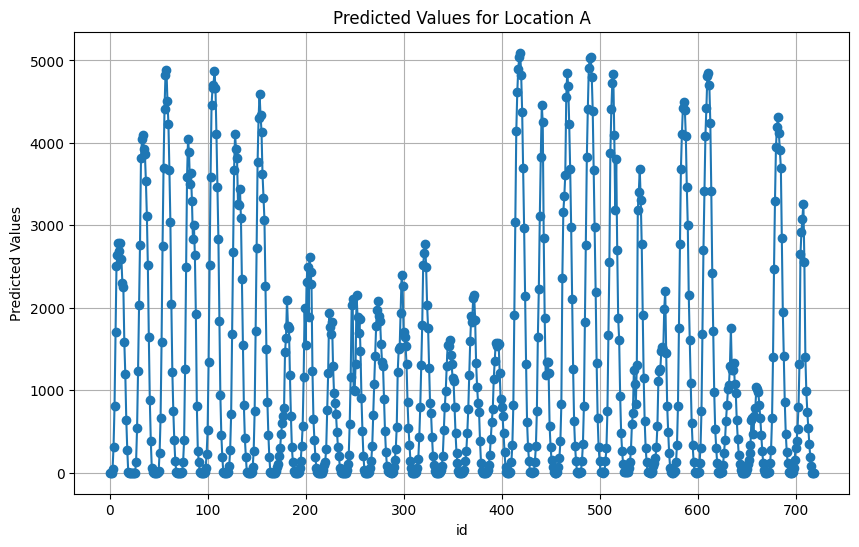

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the 'submission_A' DataFrame as described
x = submission_A['id']
y = submission_A['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location A')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

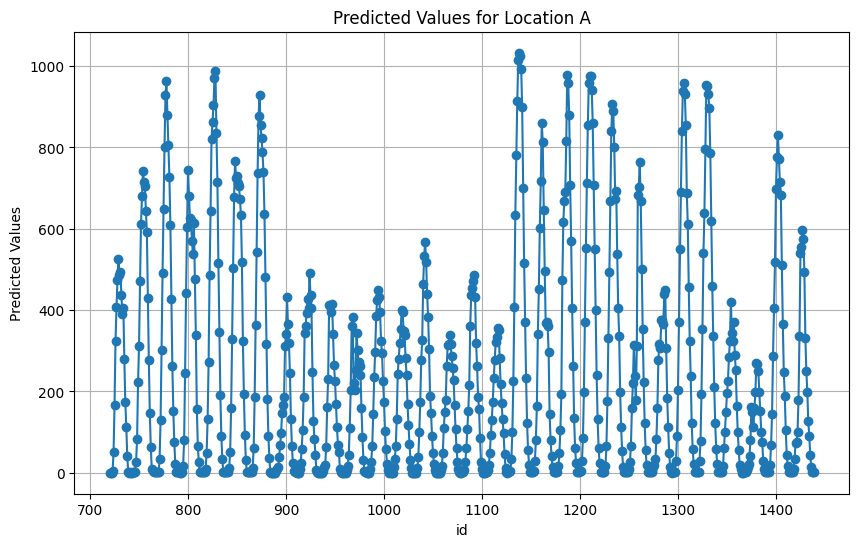

In [ ]:
x = submission_B['id']
y = submission_B['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location A')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

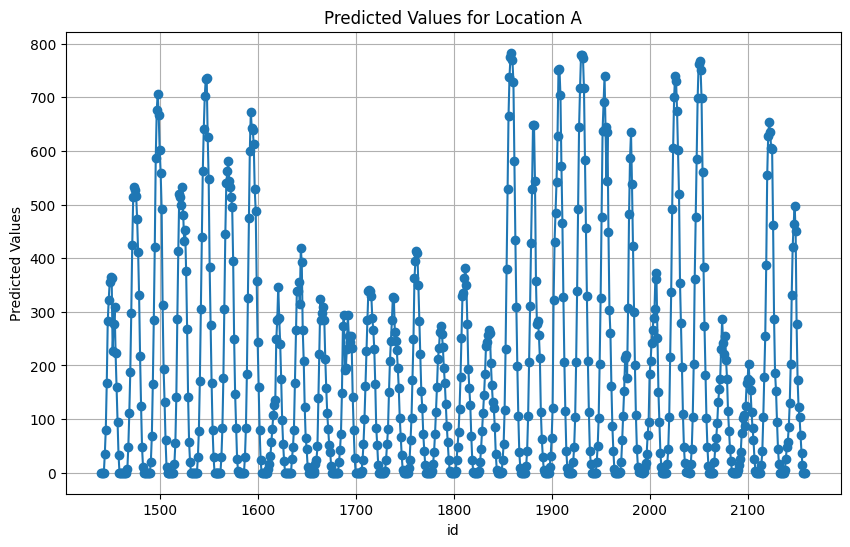

In [ ]:
x = submission_C['id']
y = submission_C['predicted_values']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')  # Adjust marker style and linestyle as needed
plt.title('Predicted Values for Location A')
plt.xlabel('id')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

#